# Introduction

Fairness in machine learning has become a critical area of research, particularly as automated decision-making systems increasingly influence societal outcomes. These systems can perpetuate biases, especially when sensitive attributes such as race, gender, or socioeconomic status interact with the data and decision processes. Addressing fairness requires not only defining what it means for an algorithm to be fair but also understanding how unfairness arises within datasets and models.

There are crieria to formalize and enforce fairness in machine learning systems:

1. **Demographic Parity (DP):** Ensures equal outcomes across groups by requiring the prediction rate to be the same for all groups. Specifically,

    $$
    P(\hat{Y} \mid A = 0) = P(\hat{Y} \mid A = 1).
    $$

2. **Equal Opportunity (EO):** Focuses on fairness in true positive rates, ensuring equal chances of favorable outcomes for all groups, requiring that:

    $$
    P(\hat{Y} = 1 \mid A = 0, Y = 1) = P(\hat{Y} = 1 \mid A = 1, Y = 1).
    $$

    This criterion emphasizes fairness in correctly identifying positive cases.

3. **Fairness Through Unawareness (FTU):** Ensures fairness by excluding sensitive attribites from the model's features. However, this approach can be undermined when proxy variables in the feature set, $X$, encode discriminatory information about $A$.

4. **Individual Fairness (IF):** Requires that individuals who are similar under a chosen metric, $d(\cdot, \cdot)$, should receive similar outcomes:
    $$
    \hat{Y}(X^{(i)}, A^{(i)}) \approx \hat{Y}(X^{(j)}, A^{(j)}).
    $$
    Defining such a metric often necessitates a deep understanding of the domain and may go beyond statistical modeling.

Despite these frameworks, ensuring fairness in practice remains challenging. For exmaple, the marginal association between sensitive attributes $A$ and outcomes $Y$ can create conflict between criteria like DP and EO. Moreover, simplistic fairness definitions often fail to address the complex ways in which unfairness enters datasets and decision processes, especially through latent relationships and indirect effects.

To address these challenges, fairness should be viewed through the lens of **causal modeling**. By explicitly modeling the causal structure of the data, we can disentangle the direct and indirect effects of sensitive attributes and other variables. This perspective allows for a more nuanced understanding of how biases arise and facilitates fair decision-making.

One way of integrating causal awareness in modeling is using **counterfactual fairness**, which defines fairness in terms of individual outcomes in actual and counterfactual scenarios. A predictor $\hat{Y}$ of $Y$ is counterfactually fair given the sensitive attribute $A = a$ and any observed variables $\mathcal{X}$ if:

$$
P(\hat{Y}_{A \leftarrow 0} = y \mid \mathcal{X} = \mathbf{x}, A = 0) = P(\hat{Y}_{A \leftarrow 1} = y \mid \mathcal{X} = \mathbf{x}, A = 0)
$$

for all $y$ and.

A decision is fair if an individual's outcome remains consistent in (a) the real world and (b) a hypothetical world where their demographic attributes differ. Counterfactual fairness thus leverages causal models to assess and mitigate bias.

Thus, a fair model can be learned by solving a optimisation with constraints entailed by causal explanation, which can be efficiently solved using gradient-based methods. The model can also be extended to allow for encoding different causal models, giving it the flexibility to address different (expert) opnions on the "right" causal models.


In [31]:
import warnings
warnings.filterwarnings("ignore", message=".*l1_ratio parameter is only used when penalty is 'elasticnet'.*")

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import torch 
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import networkx as nx

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from holisticai.datasets import load_dataset
from holisticai.bias.metrics import classification_bias_metrics

from utils import evaluate_model

# 1. Data Collection


In [32]:
compas = load_dataset('compas_two_year_recid')

df = compas.data
df.columns = df.columns.droplevel(0)

df = df.drop(columns=[
    'days_b_screening_arrest',
    'decile_score',
    'c_days_from_compas',
    'v_decile_score',
    'age_cat_25 - 45',
    'age_cat_Greater than 45',
    'age_cat_Less than 25',
    'score_text_High',
    'score_text_Low',
    'score_text_Medium',
    'v_type_of_assessment_Risk of Violence',
    'v_score_text_High',
    'v_score_text_Low',
    'v_score_text_Medium',
    'c_charge_degree_M',
])

For this experiment, we restrict our analysis on the cohort including African-Americans and Caucasians.


In [33]:
df = df[df['race'].isin(['African-American', 'Caucasian'])]

# Define mappings for known categorical columns
mappings = {
    'race': {'Caucasian': 0, 'African-American': 1},
    'sex': {'Male': 0, 'Female': 1},
    'c_charge_degree': {'F': 0, 'M': 1}  # Example of charge degree mapping
}

# Apply mappings dynamically to relevant columns
for column, mapping in mappings.items():
    if column in df.columns:
        df[column] = df[column].map(mapping)

df = df.rename(columns={'c_charge_degree_F': 'c_charge_degree'})

# Ensure all other columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5278 entries, 1 to 6170
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   priors_count     5278 non-null   int64  
 1   juv_fel_count    5278 non-null   int64  
 2   juv_misd_count   5278 non-null   int64  
 3   juv_other_count  5278 non-null   int64  
 4   c_charge_degree  5278 non-null   float64
 5   y                5278 non-null   int64  
 6   race             5278 non-null   int64  
 7   sex              5278 non-null   int64  
 8   age              5278 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 412.3 KB


In [35]:
df.head()

subfeatures,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,y,race,sex,age
1,0,0,0,0,1.0,1,1,0,34
2,4,0,0,1,1.0,1,1,0,24
4,14,0,0,0,1.0,1,0,0,41
6,0,0,0,0,0.0,0,0,1,39
7,0,0,0,0,1.0,0,0,0,27


# 2. Exploratory Data Analysis


In [36]:
# pass

# 3. Define Causal Models


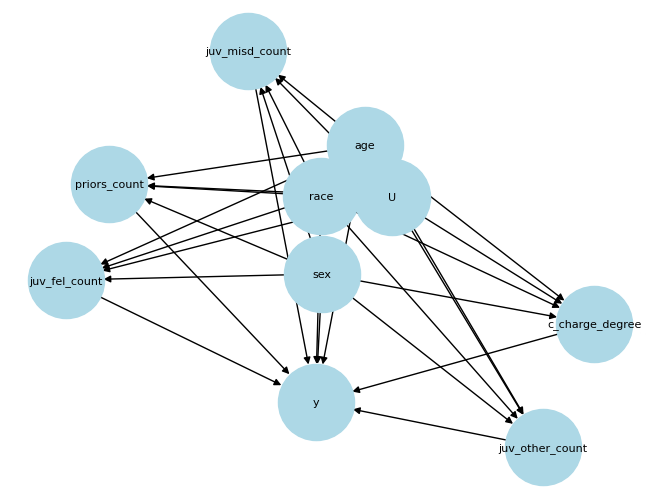

In [37]:
# 1. Define causal graph

edges = [
    ('priors_count', 'y'),
    ('juv_fel_count', 'y'),
    ('juv_misd_count', 'y'),
    ('juv_other_count', 'y'),
    ('c_charge_degree', 'y'),
    ('race', 'priors_count'),
    ('race', 'juv_fel_count'),
    ('race', 'juv_misd_count'),
    ('race', 'juv_other_count'),
    ('race', 'c_charge_degree'),
    ('race', 'y'),
    ('sex', 'priors_count'),
    ('sex', 'juv_fel_count'),
    ('sex', 'juv_misd_count'),
    ('sex', 'juv_other_count'),
    ('sex', 'c_charge_degree'),
    ('sex', 'y'),
    ('age', 'priors_count'),
    ('age', 'juv_fel_count'),
    ('age', 'juv_misd_count'),
    ('age', 'juv_other_count'),
    ('age', 'c_charge_degree'),
    ('age', 'y'),
    ('U', 'priors_count'),
    ('U', 'juv_fel_count'),
    ('U', 'juv_misd_count'),
    ('U', 'juv_other_count'),
    ('U', 'c_charge_degree'),
]

causal_graph = nx.DiGraph(edges)

nx.draw(causal_graph, nx.spring_layout(causal_graph, seed=0), with_labels=True, node_size=3000, node_color='lightblue', font_size=8)

Each node corresponds to a variable, and each set of edges into a node corresponds to the generative model (**structural equations**) between that node and its parents. The relationship can be deterministic (a function) or non-deterministic (a probability distribution), which can be learned using OLS, decision trees, NNs, etc.. Here, we will be using OLS.


In [38]:
# 2. Fit structural equations

df['U'] = np.random.normal(0, 1, df.shape[0])

causal_relationships = {
    'priors_count': ['race', 'sex', 'age', 'U'],
    'juv_fel_count': ['race', 'sex', 'age', 'U'],
    'juv_misd_count': ['race', 'sex', 'age', 'U'],
    'juv_other_count': ['race', 'sex', 'age', 'U'],
    'c_charge_degree': ['race', 'sex', 'age', 'U'],
}

structural_equations = {}

for child, parents in causal_relationships.items():
    model = sm.OLS(df[child], df[parents]).fit()  
    structural_equations[child] = model

In [39]:
for var, model in structural_equations.items():
        equation = f'{var} = '
        equation += ' + '.join([f'{coef:.2f}*{name}' for name, coef in model.params.items()])
        print(equation)

priors_count = 2.19*race + -1.42*sex + 0.07*age + -0.04*U
juv_fel_count = 0.08*race + -0.05*sex + 0.00*age + -0.01*U
juv_misd_count = 0.13*race + -0.04*sex + 0.00*age + -0.01*U
juv_other_count = 0.11*race + -0.04*sex + 0.00*age + -0.00*U
c_charge_degree = 0.30*race + 0.01*sex + 0.01*age + -0.00*U


Given a complete set of equations, we can compute the distribution of any variables had certain other variables been different, while other things being equal. This enables enable counterfactual inference using three steps as outlined by Pearl:

1. **Abduction**: Given the set of observed variables $X = \{X_1, \dots, X_d\}$, compute the values of the set of unobserved variables $U = \{U_1, \dots, U_p\}$ given the model. For non-deterministic models, compute the posterior distribution $P(U \mid X)$.
2. **Action**: Replace all occurrences of the variable $W$ with the value $w$ in the model equations.
3. **Prediction**: Using the new model equations and $U$ (or $P(U \mid X)$), compute the value of $V$ (or $P(V \mid X)$). This final step provides the value or distribution of $V_{W \gets w}$ given the observed, factual variables.


In [40]:
def abduction(df, causal_relationships, structural_equations):
    '''
    Infer a single latent variable U based on residuals across all child nodes
    that depend on U.

    TODO: Not sure if this is right.
    '''
    # Iterate through all child nodes to compute residuals
    total_residuals = 0
    count = 0
    for child, parents in causal_relationships.items():
        if 'U' in parents:
            # Predict values based on observed parents
            predicted = structural_equations[child].predict(df[parents])
            
            # Accumulate residuals
            residuals = df[child] - predicted
            total_residuals += np.mean(residuals)

            count += 1
    
    # Infer global U as the mean of residuals across all child nodes
    U = total_residuals / count

    return U


def apply_intervention(df, variable):
    df_intervened = df.copy()
    df_intervened[variable] = 1 - df_intervened[variable]

    return df_intervened


def predict_counterfactual(df_intervened, causal_relationships, structural_equations):
    df_cf = df_intervened.copy()

    for child, parents in causal_relationships.items():
        df_cf[child] = structural_equations[child].predict(df_cf[parents])

    return df_cf

In [41]:
# 3. Causal inference (counterfactuals)
df_abduct = df.copy()
df_abduct['U'] = abduction(df_abduct, causal_relationships, structural_equations)

df_cf_race = predict_counterfactual(apply_intervention(df_abduct, 'race'), causal_relationships, structural_equations)
X_cf_race = df_cf_race.drop(columns=['y'])

df_cf_sex = predict_counterfactual(apply_intervention(df_abduct, 'sex'), causal_relationships, structural_equations)
X_cf_sex = df_cf_sex.drop(columns=['y'])

# 4. Model Training


In [42]:
X = df.copy().drop(columns=['y'])
y = df['y'].copy()

In [43]:
def counterfactual_fairness(y_hat, y_hat_cf):
    epsilon = 1e-3
    return np.mean(np.maximum(0, np.abs(y_hat_cf - y_hat) - epsilon))

In [44]:
def objective(trial, X, y, X_cf_race, X_cf_sex, penalty_weight=1e10):
    params = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'penalty': 'elasticnet',
        'solver': 'saga'
    }

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=0, **params))
    ])

    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    inner_cv_scores = np.empty(5)
    for i, (train_idx, val_idx) in enumerate(cv_inner.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_cf_race_val = X_cf_race.iloc[val_idx]
        X_cf_sex_val = X_cf_sex.iloc[val_idx]

        model.fit(X_train, y_train)

        y_hat = model.predict(X_val)
        y_prob= model.predict_proba(X_val)[:, 1]

        y_prob_race = model.predict_proba(X_cf_race_val)[:, 1]
        y_prob_sex = model.predict_proba(X_cf_sex_val)[:, 1]

        penalty = (counterfactual_fairness(y_prob, y_prob_race) + counterfactual_fairness(y_prob, y_prob_sex))

        score = log_loss(y_val, y_hat) + penalty_weight * penalty
        inner_cv_scores[i] = score

    return inner_cv_scores.mean()

In [45]:
def model(X, y, X_cf_race, X_cf_sex, penalty_weight=0):
    metrics = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']}).set_index('Metric')
    cv_params = []
    penalty = []

    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    for i, (train_idx, test_idx) in enumerate(cv_outer.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_cf_race_train, X_cf_race_test = X_cf_race.iloc[train_idx], X_cf_race.iloc[test_idx]
        X_cf_sex_train, X_cf_sex_test = X_cf_sex.iloc[train_idx], X_cf_sex.iloc[test_idx]

        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_cf_race_train, X_cf_sex_train, penalty_weight), n_trials=50)

        # Best hyperparameters from the inner CV
        best_params = study.best_params
        cv_params.append(best_params)
        
        # Fit the model on the etire outer training set
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(random_state=0, **best_params))
        ])
        model.fit(X_train, y_train)

        # Predict and evaluate on the outer test set
        y_hat = model.predict(X_test)
        y_prob= model.predict_proba(X_test)

        y_prob_race = model.predict_proba(X_cf_race_test)[:, 1]
        y_prob_sex = model.predict_proba(X_cf_sex_test)[:, 1]

        penalty.append(counterfactual_fairness(y_prob[:, 1], y_prob_race) + counterfactual_fairness(y_prob[:, 1], y_prob_sex))

        metrics[i] = evaluate_model(y_test, y_hat, y_prob).values()

    return metrics, cv_params, penalty

## Counterfactual Fairness Model


In [46]:
cf_metrics, cf_params, cf_penalty = model(X, y, X_cf_race, X_cf_sex, penalty_weight=1e3)

print('Counterfactual penalty:', cf_penalty)
cf_metrics

Counterfactual penalty: [0.0488127830147939, 0.09964645781403358, 0.06071252454698531, 0.07370226065728655, 0.12322002845020866, 0.082672198664892, 0.06297571586630575, 0.10351357255548788, 0.016948468113634492, 0.03698163814859219]


,1,2,3,4,5,6,7,8,9,10
Metric,,,,,,,,,,
Accuracy,0.583344,0.631623,0.606728,0.604147,0.660426,0.623387,0.597350,0.640438,0.522177,0.556452
Precision,0.794118,0.742188,0.780220,0.714286,0.741935,0.754386,0.767442,0.753846,1.000000,0.800000
Recall,0.216867,0.381526,0.285141,0.322581,0.463710,0.346774,0.266129,0.395161,0.044355,0.145161
F1,0.340694,0.503979,0.417647,0.444444,0.570720,0.475138,0.395210,0.518519,0.084942,0.245734
ROC-AUC,0.717378,0.719120,0.699443,0.748387,0.730069,0.715308,0.677002,0.702794,0.694358,0.728870


## Full Model


In [47]:
full_metrics, full_params, full_penalty = model(X, y, X_cf_race, X_cf_sex, penalty_weight=0)

print('Counterfactual penalty:', full_penalty)
full_metrics

Counterfactual penalty: [0.27187845799690974, 0.2906306475015171, 0.28467955247259447, 0.28436265186290854, 0.2814592446460209, 0.2651645321467171, 0.27357800974652496, 0.2592148308755907, 0.2951993739225248, 0.2580146124657076]


,1,2,3,4,5,6,7,8,9,10
Metric,,,,,,,,,,
Accuracy,0.654813,0.674828,0.675606,0.701325,0.700691,0.676037,0.645449,0.663306,0.649418,0.670923
Precision,0.673267,0.672489,0.701493,0.718310,0.705357,0.692308,0.641256,0.671362,0.671795,0.695000
Recall,0.546185,0.618474,0.566265,0.616935,0.637097,0.580645,0.576613,0.576613,0.528226,0.560484
F1,0.603104,0.644351,0.626667,0.663774,0.669492,0.631579,0.607219,0.620390,0.591422,0.620536
ROC-AUC,0.726145,0.731672,0.705330,0.757200,0.747552,0.720478,0.702578,0.723546,0.706845,0.744364


## Blind Model


In [48]:
mask = ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']

blind_metrics, blind_params, blind_penalty = model(X[mask], y, X_cf_race[mask], X_cf_sex[mask], penalty_weight=0)

print('Counterfactual penalty:', blind_penalty)
blind_metrics

Counterfactual penalty: [0.2658992102270975, 0.2698544405232869, 0.2678812710917382, 0.27128804217960867, 0.24277448846801974, 0.24583948572382075, 0.26281443801806154, 0.25066343523490536, 0.2702516318319941, 0.25440964968840896]


,1,2,3,4,5,6,7,8,9,10
Metric,,,,,,,,,,
Accuracy,0.620374,0.652222,0.631926,0.649078,0.647465,0.625346,0.635426,0.634505,0.628808,0.619400
Precision,0.687075,0.696629,0.680723,0.697674,0.715190,0.670732,0.680473,0.689441,0.676829,0.642857
Recall,0.405622,0.497992,0.453815,0.483871,0.455645,0.443548,0.463710,0.447581,0.447581,0.471774
F1,0.510101,0.580796,0.544578,0.571429,0.556650,0.533981,0.551559,0.542787,0.538835,0.544186
ROC-AUC,0.673367,0.703675,0.681731,0.707841,0.718563,0.701735,0.659526,0.683936,0.683338,0.692045


# 5. Model Evaluation


In [49]:
X_train, X_test, y_train, y_test, _, X_cf_race_test, _, X_cf_sex_test = train_test_split(X, y, X_cf_race, X_cf_sex, test_size=0.2)

In [56]:
group_1 = X_test['sex']
group_0 = 1 - group_1

In [57]:
filtered_accuracy = cf_metrics.loc['Accuracy'][np.asarray(cf_penalty) < 0.8]

if not filtered_accuracy.empty:
    idx = filtered_accuracy.idxmax()
else:
    idx = None  # Fallback if no values satisfy the constraint

print(idx)

5


In [58]:
cf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=0, **cf_params[idx]))
])
cf_model.fit(X_train, y_train)

cf_y_hat = cf_model.predict(X_test)
cf_y_hat_race = cf_model.predict(X_cf_race_test)
cf_y_hat_sex = cf_model.predict(X_cf_sex_test)

cf_df = pd.DataFrame({
    'True': y_test, 
    'Predicted': cf_y_hat, 
    'CF (race)': cf_y_hat_race,
    'CF (sex)': cf_y_hat_sex,
})

cf_bias_metrics = classification_bias_metrics(
    group_a = group_0,
    group_b = group_1,
    y_true = y_test,
    y_pred = cf_y_hat,
)

In [59]:
idx = np.argmax(full_metrics.loc['Accuracy']) - 1

full_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=0, **full_params[idx]))
])

full_model.fit(X_train, y_train)
full_y_hat = full_model.predict(X_test)
full_y_hat_race = full_model.predict(X_cf_race_test)
full_y_hat_sex = full_model.predict(X_cf_sex_test)

full_df = pd.DataFrame({
    'True': y_test, 
    'Predicted': full_y_hat, 
    'CF (race)': full_y_hat_race,
    'CF (sex)': full_y_hat_sex,
})

full_bias_metrics = classification_bias_metrics(
    group_a = group_0,
    group_b = group_1,
    y_true = y_test,
    y_pred = full_y_hat,
)

In [60]:
idx = np.argmax(blind_metrics.loc['Accuracy']) - 1

blind_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=0, **blind_params[idx]))
])
blind_model.fit(X_train[mask], y_train)

blind_y_hat = blind_model.predict(X_test[mask])
blind_y_hat_race = blind_model.predict(X_cf_race_test[mask])
blind_y_hat_sex = blind_model.predict(X_cf_sex_test[mask])

blind_df = pd.DataFrame({
    'True': y_test, 
    'Predicted': blind_y_hat, 
    'CF (race)': blind_y_hat_race,
    'CF (sex)': blind_y_hat_sex,
})

blind_bias_metrics = classification_bias_metrics(
    group_a = group_0,
    group_b = group_1,
    y_true = y_test,
    y_pred = blind_y_hat,
)

In [61]:
combined_metrics = pd.concat(
    [full_bias_metrics[['Reference', 'Value']], blind_bias_metrics[['Value']], cf_bias_metrics[['Value']]],
    axis=1
)

# Rename the columns to dataset names
combined_metrics.columns = ['Reference', 'Full', 'Blind', 'CF']

combined_metrics

,Reference,Full,Blind,CF
Metric,,,,
Statistical Parity,0,0.350525,0.188070,0.173433
Disparate Impact,1,4.763529,2.420970,6.054326
Four Fifths Rule,1,0.209928,0.413058,0.165171
Cohen D,0,0.754987,0.422729,0.464731
2SD Rule,0,9.284265,5.350125,5.865848
Equality of Opportunity Difference,0,0.425448,0.241272,0.238145
False Positive Rate Difference,0,0.243161,0.108381,0.091127
Average Odds Difference,0,0.334305,0.174827,0.164636
Accuracy Difference,0,0.028031,0.006559,-0.004764


# References


Kusner, M., Loftus, J., Russell, C. and Silva, R. (2017). Counterfactual Fairness. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.1703.06856.

Nabi, R. and Shpitser, I. (2017). Fair Inference On Outcomes. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.1705.10378.

‌Peters, J.C., Mooij, J.M., Dominik Janzing and Bernhard Schölkopf (2014). Causal discovery with continuous additive noise models. Journal of Machine Learning Research, 15(1), pp.2009–2053. doi:https://doi.org/10.5555/2627435.2670315.

Russell, C., Kusner, M.J., Loftus, J. and Silva, R. (2017). When Worlds Collide: Integrating Different Counterfactual Assumptions in Fairness. Advances in Neural Information Processing Systems, [online] 30. Available at: https://papers.nips.cc/paper_files/paper/2017/hash/1271a7029c9df08643b631b02cf9e116-Abstract.html [Accessed 25 Nov. 2024].
